In [1]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))


In [2]:
# stock_list[stock_list['종목명'].str.contains('중공')]

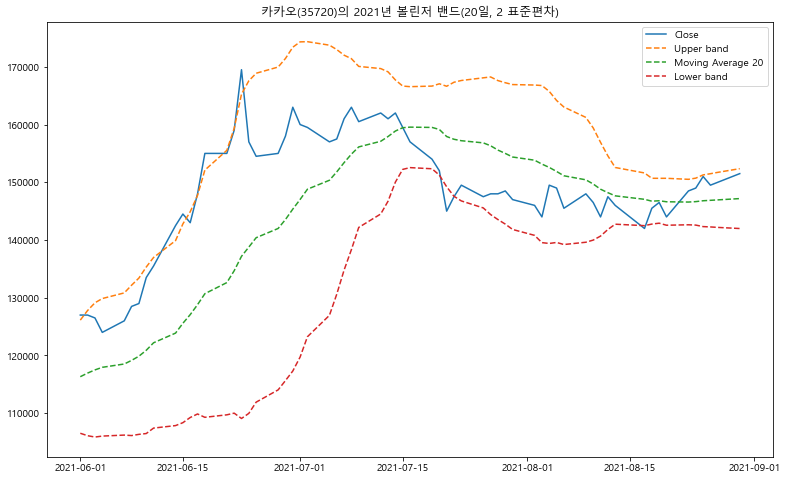

In [328]:
name = '카카오'
fromdate = str(20210501)
todate = str(20210830)

ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
df = stock.get_market_ohlcv_by_date(fromdate=fromdate, todate=todate, ticker=ticker)


df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
df = df[19:] # 20일 이동평균을 구했기 때문에 20번째 행부터 값이 들어가 있음


plt.figure(figsize=(13, 8))
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
plt.plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
plt.plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
plt.title(f'{name}({int(ticker.values)})의 2021년 볼린저 밴드(20일, 2 표준편차)')
plt.legend(loc='best');
plt.show()

In [329]:
df['volatility'] = (df['upper'] - df['lower'])/2
df.head()

,Open,High,Low,Close,Volume,ma20,stddev,upper,lower,volatility
날짜,,,,,,,,,,
2021-06-01,123500,127000,123000,127000,3573808,116325.0,4899.718037,126124.436074,106525.563926,9799.436074
2021-06-02,128000,129500,126000,127000,2597446,116950.0,5423.875096,127797.750191,106102.249809,10847.750191
2021-06-03,127500,128500,126000,126500,1737466,117500.0,5812.871380,129125.742761,105874.257239,11625.742761
2021-06-04,126000,126000,123000,124000,2668254,117950.0,5955.757939,129861.515879,106038.484121,11911.515879
2021-06-07,125000,127000,125000,126000,1905198,118525.0,6156.885320,130838.770640,106211.229360,12313.770640


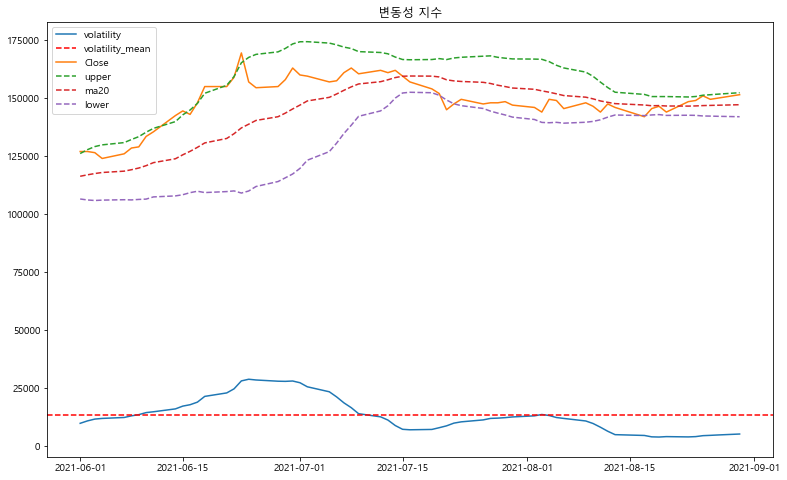

In [330]:
plt.figure(figsize=(13, 8))
plt.plot(df['volatility'])
plt.axhline(df['volatility'].mean(), color='red', linestyle='--')
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
plt.plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
plt.plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
plt.legend(['volatility', 'volatility_mean', 'Close', 'upper', 'ma20', 'lower'])
plt.title('변동성 지수')
plt.show()

In [331]:
df1 = df.copy().loc[:,('Close','ma20','volatility')]
df1.insert(0, column='f_close', value=0)
df1.insert(0, column='f_ma20', value=0)
df1.insert(0, column='f_vol', value=0)
df1.insert(0, column='ff_vol', value=0)

for i in range(1, len(df1)):
    df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
    df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
    df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
for i in range(1, len(df1)):
    df1['ff_vol'][i] = df1['f_vol'][i] - df1['f_vol'][i-1]

df1.head()

C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/2118246422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/2118246422.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/2118246422.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,ff_vol,f_vol,f_ma20,f_close,Close,ma20,volatility
날짜,,,,,,,
2021-06-01,0,0,0,0,127000,116325.0,9799.436074
2021-06-02,1048,1048,625,0,127000,116950.0,10847.750191
2021-06-03,-271,777,550,-500,126500,117500.0,11625.742761
2021-06-04,-492,285,450,-2500,124000,117950.0,11911.515879
2021-06-07,117,402,575,2000,126000,118525.0,12313.770640


In [332]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2 = df1.copy()
df2[:] = scaler.fit_transform(df2[:])
df2.head()

,ff_vol,f_vol,f_ma20,f_close,Close,ma20,volatility
날짜,,,,,,,
2021-06-01,0.619505,0.430805,0.328859,0.543478,0.065934,0.000000,0.237347
2021-06-02,0.859432,0.605123,0.496644,0.543478,0.065934,0.014459,0.279418
2021-06-03,0.557463,0.560047,0.476510,0.521739,0.054945,0.027183,0.310640
2021-06-04,0.506868,0.478210,0.449664,0.434783,0.000000,0.037594,0.322108
2021-06-07,0.646291,0.497671,0.483221,0.630435,0.043956,0.050896,0.338251


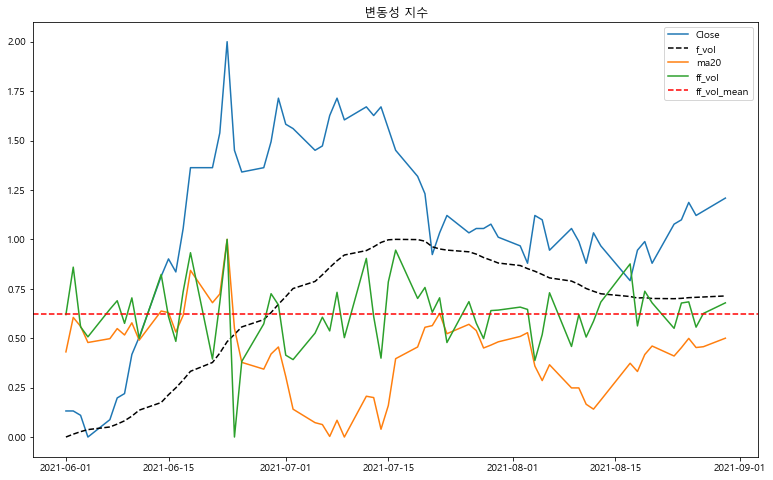

In [333]:
plt.figure(figsize=(13, 8))
plt.plot(df2.index, df2['Close']*2, label='Close')
plt.plot(df2['ma20'], color='black', linestyle='--')
plt.plot(df2['f_vol'])
plt.plot(df2['ff_vol'])
plt.axhline(df2['ff_vol'].mean(), color='red', linestyle='--')
plt.legend(['Close', 'f_vol','ma20', 'ff_vol', 'ff_vol_mean',])
plt.title('변동성 지수')
plt.show()

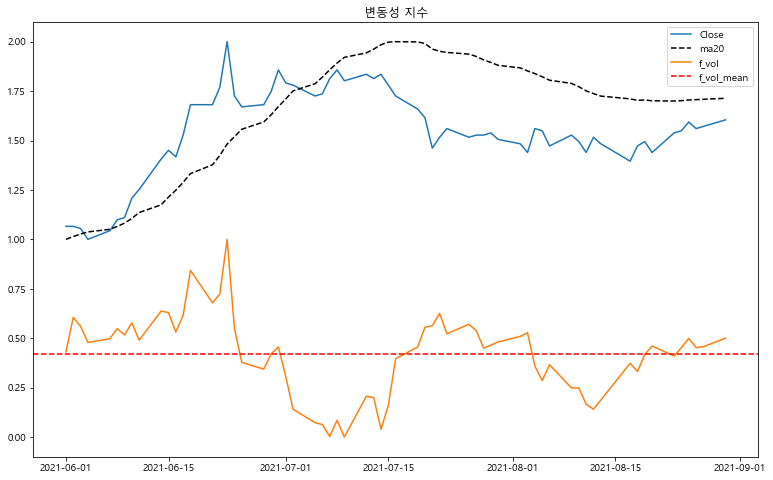

In [334]:
import numpy as np


plt.figure(figsize=(13, 8))
plt.plot(df2.index, df2['Close']+1, label='Close')
plt.plot(df2['ma20']+1, color='black', linestyle='--')
plt.plot(df2['f_vol'])
plt.axhline(df2['f_vol'].mean(), color='red', linestyle='--')
plt.legend(['Close', 'ma20','f_vol', 'f_vol_mean',])
plt.title('변동성 지수')
plt.show()

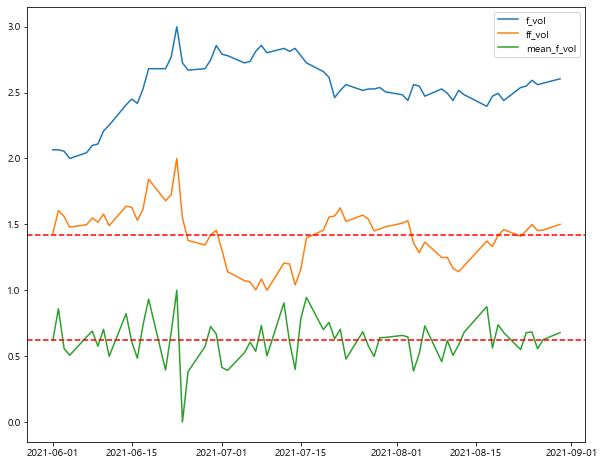

In [335]:
plt.figure(figsize=(10,8))
plt.plot(df2['Close']+2)
plt.plot(df2['f_vol']+1)
plt.plot(df2['ff_vol']) 
plt.axhline(df2['f_vol'].mean()+1, color='red', linestyle='--')
plt.axhline(df2['ff_vol'].mean(), color='red', linestyle='--')
plt.legend([ 'f_vol', 'ff_vol', 'mean_f_vol'])
plt.show()

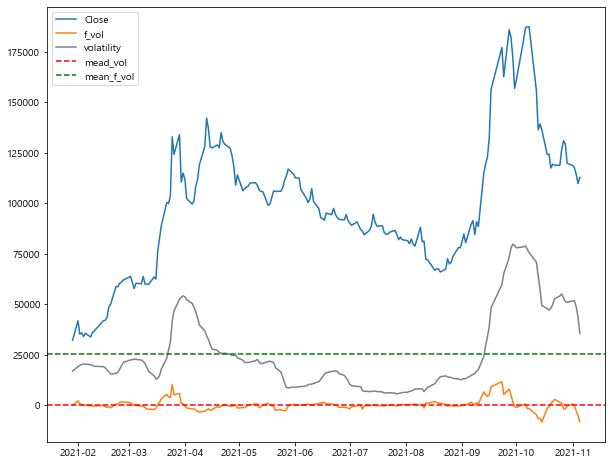

In [264]:
plt.figure(figsize=(10,8))
plt.plot(df1['Close'])
plt.plot(df1['f_vol'])
plt.plot(df1['volatility'], color='gray', linestyle='-')
plt.axhline(df1['f_vol'].mean(), color='red', linestyle='--')
plt.axhline(df1['volatility'].mean(), color='green', linestyle='--')
plt.legend(['Close', 'f_vol', 'volatility', 'mead_vol', 'mean_f_vol'])
plt.show()

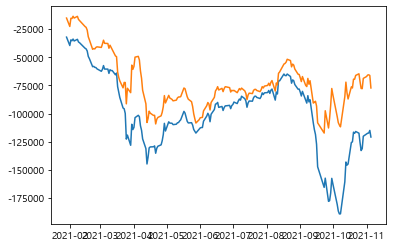

In [265]:
plt.plot(df1['f_vol'] - df1['Close'])
plt.plot(df1['volatility'] - df1['Close'])
plt.show()

In [185]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(df1['f_vol'] - df1['Close'], df1['volatility'] - df1['Close'])
pvalue

0.0021313754537441304

In [186]:
score, pvalue, _ = coint(df1['f_vol'], df1['f_ma20'])
pvalue

1.7622632179035787e-09

In [187]:
score, pvalue, _ = coint(df1['f_vol'], df1['volatility'])
pvalue

2.8716988171819003e-09

In [188]:
score, pvalue, _ = coint(df1['f_vol'], df1['Close'])
pvalue

2.2511607528972333e-09

In [189]:
score, pvalue, _ = coint(df1['f_vol'], df1['f_ma20'])
pvalue

1.7622632179035787e-09

In [190]:
score, pvalue, _ = coint(df1['Close'], df1['f_close'])
pvalue

0.8849563263336255

In [191]:
score, pvalue, _ = coint(df1['ma20'], df1['f_ma20'])
pvalue

0.8588771891350611

In [192]:
df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['upper']*0.98)].shape[0] / df.shape[0]

0.0958904109589041

In [193]:
df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['ma20']*1.1)].shape

(83, 10)

In [194]:
tmp = df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['ma20']*1.1)].index
tmp

DatetimeIndex(['2020-04-07', '2020-04-09', '2020-04-10', '2020-04-14',
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-05-29',
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
               '2020-07-06', '2020-07-15', '2020-07-21', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-03', '2020-08-04', '2020-08-06', '2020-08-11',
               '2020-08-12', '2020-08-13', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-11-13',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-30', '2020-12-01', '2020-12-02',
               '2020-12-03', '2020-12-04', '2020-12-07', '2020-12-08',
      